In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [15]:
## Read the supercritical coal power plant data

super_critical = pd.read_csv('CEEW_supercritical_with_ws_price.csv')

all_heat_rate = super_critical['Actual SHR']* 3.96567/1000
all_capacity  = super_critical['Capacity']
all_age       = super_critical['Age']
all_region     = super_critical['Region']
all_PLF        = super_critical['Actual avg PLF']
all_water_stress = super_critical['bws_score']
all_price = super_critical['coal_price']
#all_temperature = super_critical['avg_max_temp']

In [17]:
data = pd.DataFrame({'heat_rate': all_heat_rate,
                     'capacity': all_capacity,
                     'age': all_age, 
                     'PLF': all_PLF,
                     'water stress': all_water_stress,
                     'region': all_region,
                     'price': all_price,
                      #'temperature': all_temperature
                     })

# change the state to one hot encoding
data = pd.get_dummies(data, columns=['region']) # aggregate the states here. 
print(data.head())
# data.columns = ['Heat rate', 'Capacity', 'Age', 'Load factor', 'Water Stress', 
#                 'Coal Price', 'Temperature', 'East Region', 'North Region',
#                   'South Region', 'West Region']
data.columns = ['Heat rate', 'Capacity', 'Age', 'Load factor', 'Water Stress', 'Coal Price',
                'East Region', 'North Region', 'South Region', 'West Region']

   heat_rate  capacity       age       PLF  water stress  price  region_ER  \
0  10.619654     800.0  0.342231  0.005858      0.083791   1.66       True   
1  10.423931     800.0  1.067762  0.171927      0.480176   1.72      False   
2   9.845797     800.0  1.960301  0.633565      0.250206   2.04      False   
3  10.429779     800.0  2.091718  0.191133      0.139977   1.59      False   
4  10.657335     800.0  3.091034  0.040648      0.331244   3.46      False   

   region_NR  region_SR  region_WR  
0      False      False      False  
1      False      False       True  
2      False       True      False  
3      False      False       True  
4      False       True      False  


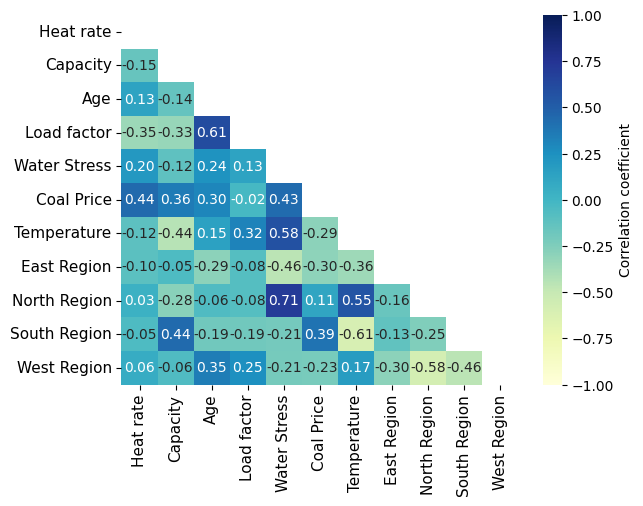

In [4]:
mask = np.triu(np.ones_like(data.corr()))
plt.rcParams.update({'font.size': 10})
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True,  fmt=".2f", mask=mask,
                      vmin=-1, vmax=1)
dataplot.set_xticklabels(dataplot.get_xticklabels(), fontsize=11)
dataplot.set_yticklabels(dataplot.get_yticklabels(), fontsize=11)
cbar = dataplot.collections[0].colorbar
cbar.set_label('Correlation coefficient')
plt.savefig('ML_training_plots/Feature_correlation_super.png', bbox_inches='tight')

2. Fit the prediction model using data

In [8]:
X = data.drop('Heat rate', axis=1)
y = data['Heat rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# add constant
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

(62, 9) (16, 9) (62,) (16,)


In [9]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict

In [20]:
good_models = {
    'GradientBoostingRegressor': GradientBoostingRegressor(learning_rate=0.1, loss='absolute_error', max_depth=30, n_estimators=300),
    'RandomForestRegressor': RandomForestRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=2),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=5),
    'XGBRegressor': XGBRegressor(learning_rate=0.1, max_depth=2, n_estimators=600),
    'LinearRegression': LinearRegression(),
    'RidgeRegression': Ridge(alpha=10),
    'SVR': SVR(C=0.01, gamma=1, kernel='poly'),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=1, weights='uniform'),
}

In [21]:
# Cross validation
kf = KFold(n_splits=5)
res = {}

# use mean squared error, mean absolute error, mean absolute percentage error
for name, model in good_models.items():
    print(name)
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error',
                                                                     'neg_mean_absolute_percentage_error', 'r2'))
    res[name] = scores

GradientBoostingRegressor
RandomForestRegressor
DecisionTreeRegressor
XGBRegressor
LinearRegression
RidgeRegression
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. In

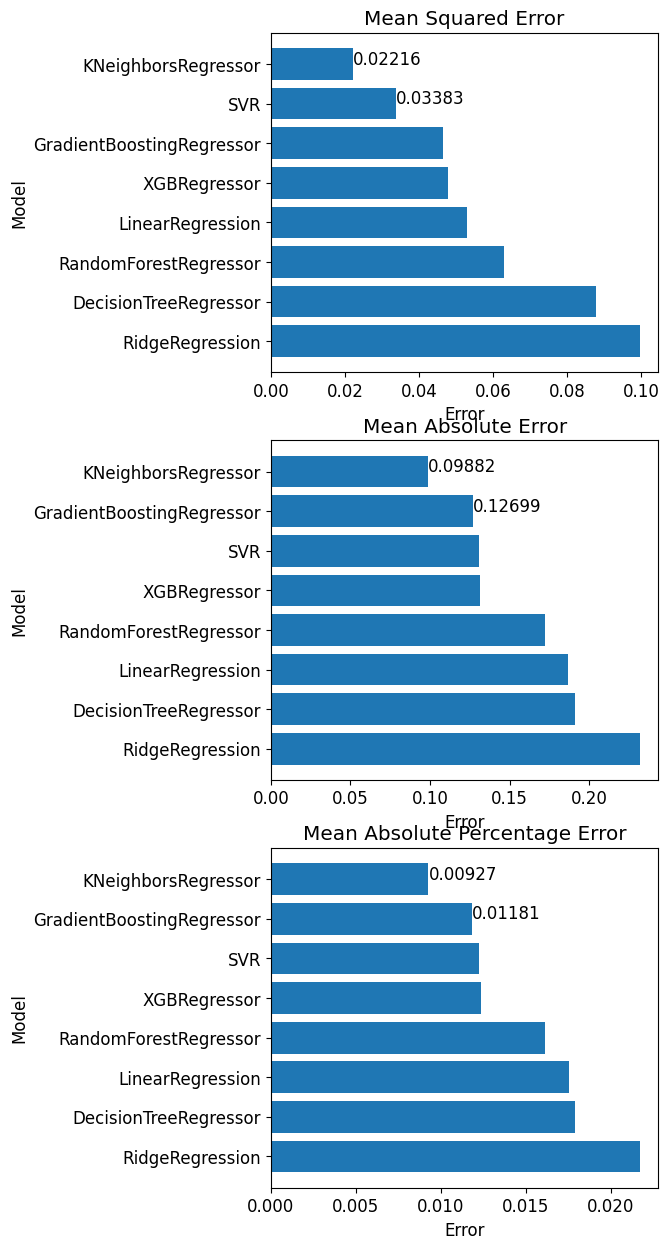

In [22]:
# taking the negative mean. test_neg_mean_squared_error, test_neg_mean_absolute_error, test_neg_mean_absolute_percentage_error
res_mean = {name: {'test_mean_squared_error': -np.mean(scores['test_neg_mean_squared_error']),
                  'test_mean_absolute_error': -np.mean(scores['test_neg_mean_absolute_error']),
                  'test_mean_absolute_percentage_error': -np.mean(scores['test_neg_mean_absolute_percentage_error']),
                  'test_mean_r2': np.mean(scores['test_r2'])} for name, scores in res.items()}

titles = {
    'test_mean_squared_error': 'Mean Squared Error',
    'test_mean_absolute_error': 'Mean Absolute Error',
    'test_mean_absolute_percentage_error': 'Mean Absolute Percentage Error',
    'test_mean_r2': 'Mean R Square',
}

# store the results
res_df = pd.DataFrame(res_mean).T
res_df.to_csv('ML_training_plots/Model_comparison_super.csv')

# 3 horizontal bar plots for each of the errors.
fig, ax = plt.subplots(3, 1, figsize=(5, 15))
plt.rcParams.update({'font.size': 12})
for i, error in enumerate(['test_mean_squared_error', 'test_mean_absolute_error', 'test_mean_absolute_percentage_error']):
    # sort by the error
    res_mean = dict(sorted(res_mean.items(), key=lambda item: -item[1][error]))

    ax[i].barh(list(res_mean.keys()), [res_mean[name][error] for name in res_mean])
    ax[i].set_title(titles[error])
    ax[i].set_xlabel('Error')
    ax[i].set_ylabel('Model')

    # label bars with values
    for index, value in enumerate([res_mean[name][error] for name in res_mean]):
        if index > 5:
            ax[i].text(value, index, str(round(value, 5)))
# save
plt.savefig('ML_training_plots/Model_comparison_super.png', bbox_inches='tight')

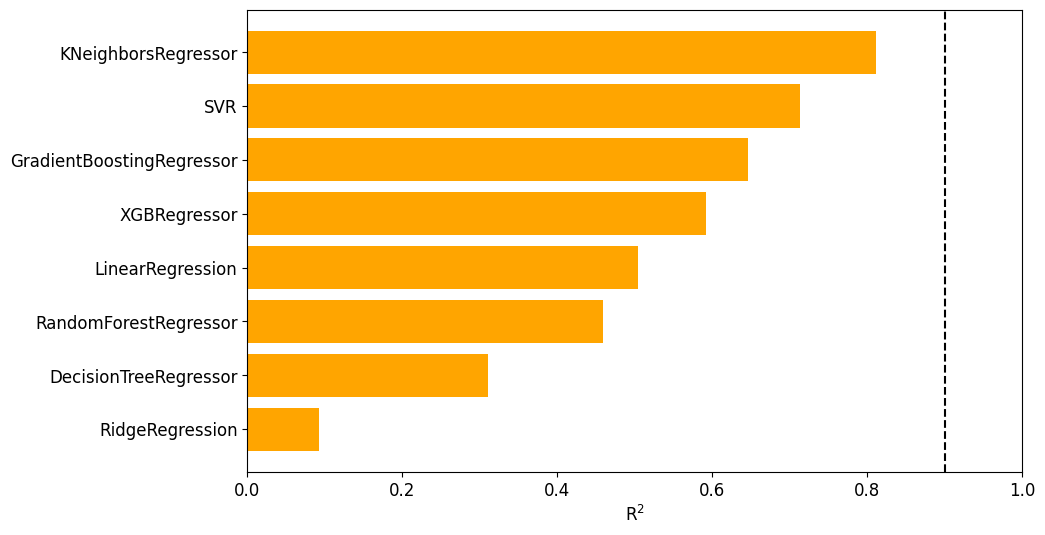

In [32]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 6))
# sort the res_mean for test_mean_r2, from high to low
res_mean = dict(sorted(res_mean.items(), key=lambda item: item[1]['test_mean_r2']))
plt.barh(list(res_mean.keys()), [res_mean[name]['test_mean_r2'] for name in res_mean], color='orange')
plt.axvline(x=0.9, linestyle='--', color='k')
plt.xlim(0, 1)
plt.xlabel('R$^2$')
plt.savefig('ML_training_plots/Model_comparison_R2_super.png', bbox_inches='tight')

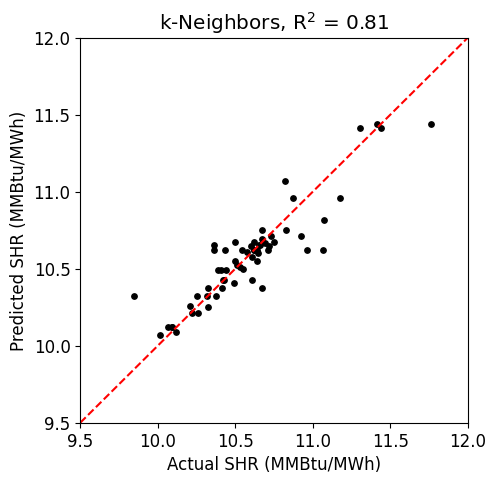

In [24]:
y_pred = cross_val_predict(good_models['KNeighborsRegressor'], X_train, y_train, cv=kf)

plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_pred, s=15, color='black')
plt.plot([9, 12], [9, 12], linestyle='--', color='red')
plt.xlabel('Actual SHR (MMBtu/MWh)')
plt.ylabel('Predicted SHR (MMBtu/MWh)')
plt.title('k-Neighbors, '+'R$^2$ = '+str(np.round(max([res_mean[name]['test_mean_r2'] for name in res_mean]), 2)))
plt.xlim([9.5, 12])
plt.ylim([9.5, 12])
plt.savefig('ML_training_plots/Parity_plots_supercritical.png', bbox_inches='tight')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


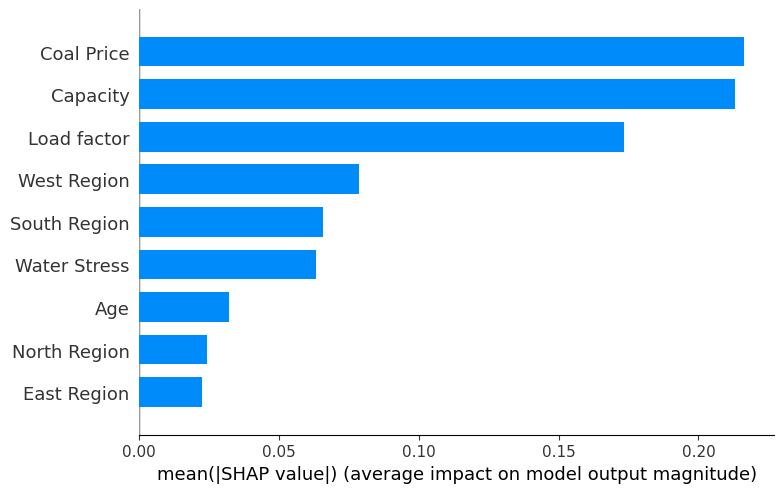

In [25]:
import shap
idx = 1
sorted_model_names = sorted(good_models.keys(), key=lambda name: res_mean[name]['test_mean_squared_error'])
for name in sorted_model_names:
    model = good_models[name]
    if (name in ['KNeighborsRegressor', 'SVR', 'LinearRegression', 'RidgeRegression']):
        model.fit(X_train, y_train)
        explainer = shap.Explainer(model.predict, X_train)
        shap_values = explainer(X_train)
    else:
        model.fit(X_train, y_train)
        explainer = shap.Explainer(model)
        shap_values = explainer(X_train)
    features_names = [0] + list(X.columns)
    shap.summary_plot(shap_values, X_train,
                      feature_names=[0] + list(X.columns), plot_type='bar',
                      max_display=9, show=False)
    plt.savefig('./SHAP_plot/'+str(name)+'_summary_supercritical.png')
    idx += 1

3. Predict the heat rate of GEM database

In [26]:
## Read the supercritical coal power plant data

gem_coal = pd.read_csv('gem_with_ws_price.csv')
gem_super_critical = gem_coal[gem_coal['Combustion technology']=='supercritical']
gem_super_critical = gem_super_critical[gem_super_critical['Status']=='operating']

gem_heat_rate = gem_super_critical['Heat rate (Btu per kWh)'] /1000
gem_capacity  = gem_super_critical['Capacity (MW)']
gem_age       = 50-gem_super_critical['Remaining plant lifetime (years)']
gem_state     = gem_super_critical['Subnational unit (province, state)']
gem_price = gem_super_critical['coal_price']
gem_water_stress = gem_super_critical['bws_score']

gem_state = gem_state.reindex()

# replace Punjab state with punjab
gem_state = gem_state.replace('Punjab state', 'Punjab')

state_to_zone = pd.read_csv('30_to_5zones.csv')
gem_state_with_zone = pd.merge(gem_super_critical, state_to_zone, left_on='Subnational unit (province, state)', right_on='States', how='left')
gem_zone = gem_state_with_zone["Region_y"]

good_models['KNeighborsRegressor'].fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1)

In [27]:
for i in [0.5, 0.7, 0.9]:
    X_prediction = pd.DataFrame(
    {
        "heat_rate": gem_heat_rate.values,
        "capacity": gem_capacity.values,
        "age": gem_age.values,
        "PLF": np.array([i] * len(gem_heat_rate)),
        "water stress": gem_water_stress,
        "region": gem_zone.values,
        "price": gem_price
    }
    )
    X_prediction = pd.get_dummies(
        X_prediction, columns=["region"]
    )  # aggregate the states here.
    X_prediction.columns = ['Heat rate', 'Capacity', 'Age', 'Load factor', 'Water Stress', 
                'Coal Price', 'East Region', 'North Region',
                  'South Region', 'West Region']
    X_prediction = X_prediction.drop("Heat rate", axis=1)

    X_prediction = scaler.transform(X_prediction)
    X_prediction = np.c_[np.ones(X_prediction.shape[0]), X_prediction]

    # replace nan with 0
    X_prediction = np.nan_to_num(X_prediction)

    predicted_gem_heat_value = good_models['GradientBoostingRegressor'].predict(X_prediction)
    gem_super_critical['Predicted_HR_'+str(np.round(i*100))] = predicted_gem_heat_value

print(gem_super_critical.columns)

Index(['Tracker ID', 'TrackerLOC', 'ParentID', 'Wiki page', 'Country',
       'Subnational unit (province, state)', 'Unit', 'Plant', 'Chinese Name',
       'Other names', 'Owner', 'Parent', 'Capacity (MW)', 'Status', 'Year',
       'RETIRED', 'Planned Retire', 'Combustion technology', 'Coal type',
       'Coal source', 'Location', 'Local area (taluk, county)',
       'Major area (prefecture, district)', 'Subregion', 'Region',
       'Previous Region', 'Latitude', 'Longitude', 'Accuracy', 'Permits',
       'Captive', 'Captive industry use', 'Captive residential use',
       'Alternate Fuel', 'Heat rate (Btu per kWh)',
       'Emission factor (kg of CO2 per TJ)', 'Capacity factor',
       'Annual CO2 (million tonnes / annum)', 'Lifetime CO2',
       'Remaining plant lifetime (years)', 'bws_score', 'coal_price',
       'Predicted_HR_50.0', 'Predicted_HR_70.0', 'Predicted_HR_90.0'],
      dtype='object')


In [28]:
gem_super_critical = gem_super_critical[['Tracker ID', 'Wiki page', 'Country',
       'Subnational unit (province, state)','Unit', 'Plant', 'Capacity (MW)', 'Year',
       'Combustion technology', 'Status', 'Latitude', 'Longitude','Heat rate (Btu per kWh)', 
       'Remaining plant lifetime (years)', 'bws_score', 'coal_price', 
       'Predicted_HR_50.0', 'Predicted_HR_70.0', 'Predicted_HR_90.0']]


gem_super_critical = gem_super_critical.reindex()

In [29]:
print(gem_super_critical.columns)
gem_super_critical.to_csv('gem_predicted_supercritical.csv')

Index(['Tracker ID', 'Wiki page', 'Country',
       'Subnational unit (province, state)', 'Unit', 'Plant', 'Capacity (MW)',
       'Year', 'Combustion technology', 'Status', 'Latitude', 'Longitude',
       'Heat rate (Btu per kWh)', 'Remaining plant lifetime (years)',
       'bws_score', 'coal_price', 'Predicted_HR_50.0', 'Predicted_HR_70.0',
       'Predicted_HR_90.0'],
      dtype='object')


/var/folders/9p/t6ljp_1516q16t2lqgyjw0w80000gp/T/ipykernel_52220/1628253694.py:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


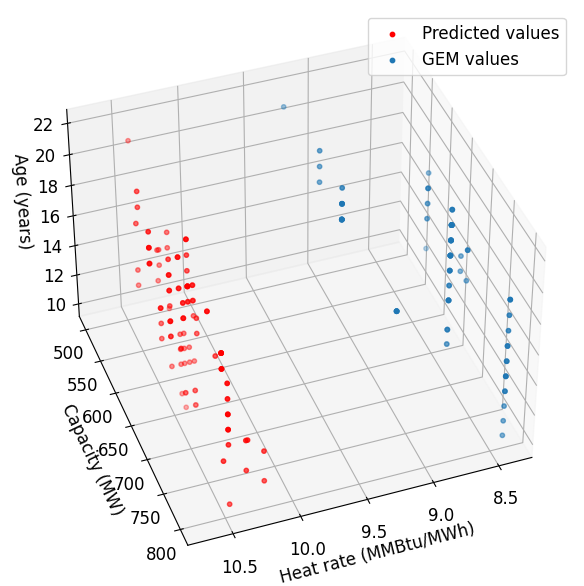

In [30]:

ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = predicted_gem_heat_value
y = gem_capacity
ax.scatter(x, y, zs=gem_age, zdir='z', color='red', s=10, label='Predicted values')

x1 = gem_heat_rate
y1 = gem_capacity
ax.scatter(x1, y1, zs=gem_age, zdir='z', color='tab:blue', s=10, label='GEM values')

# Make legend, set axes limits and labels
ax.legend()
ax.set_xlabel('Heat rate (MMBtu/MWh)')
ax.set_ylabel('Capacity (MW)')
ax.set_zlabel('Age (years)')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=40., azim=70)
ax.dist = 10


plt.tight_layout()
plt.savefig('ML_training_plots/Gem_coal_3D_prediction_charateristics_super.png')

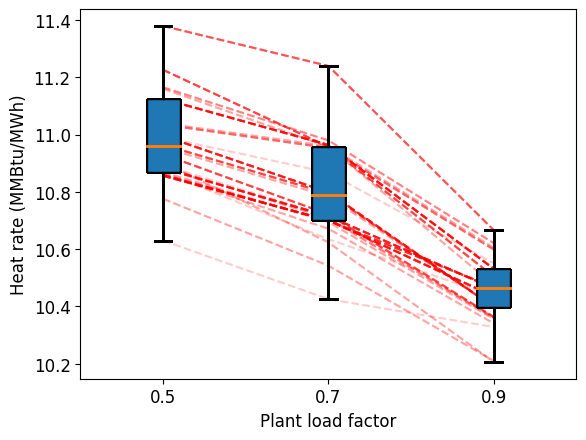

In [31]:
plt.figsize=(10, 6)
plt.rcParams.update({'font.size': 12})
for i in range(len(gem_super_critical)):
    plt.plot([gem_super_critical['Predicted_HR_50.0'].iloc[i], gem_super_critical['Predicted_HR_70.0'].iloc[i], gem_super_critical['Predicted_HR_90.0'].iloc[i]], '--',
             color='red', alpha=0.2)
    plt.boxplot([gem_super_critical['Predicted_HR_50.0'], gem_super_critical['Predicted_HR_70.0'], gem_super_critical['Predicted_HR_90.0']], positions=[0, 1, 2], widths=0.2, patch_artist=True)
plt.ylabel('Heat rate (MMBtu/MWh)')
plt.xticks(np.arange(0, 3), ['0.5', '0.7', '0.9'])
plt.ylabel('Heat rate (MMBtu/MWh)')
plt.xlabel('Plant load factor')
plt.savefig('ML_training_plots/varying_load_super.png', bbox_inches='tight')